# Adversarial Image Captioning Attack

### Import Libraries, Set Seeds, and Select GPU

In [1]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

c:\Users\Yoshio\OneDrive\Bildung\Master (CBS)\Semester-03\Advanced ML for NLP\final_project\Advanced-Machine-Learning-for-Natural-Language-Processing\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


### Load COCO Mini Dataset

In [3]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [4]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [5]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [6]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


### Image Loading Helper

In [7]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


### Visual Inspection of a Sample Image

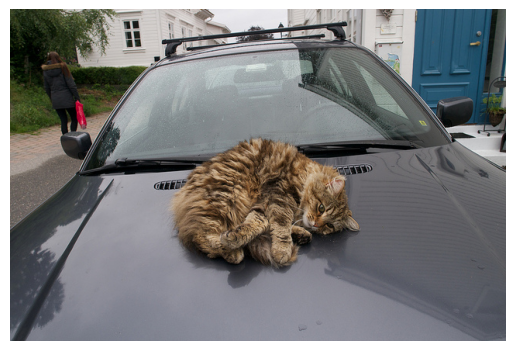

Image index: 6000, image_id: 190360
Ground truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [8]:
# Choose an image to show
idx = 6000

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


### Load ViT-GPT2

In [9]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


In [10]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1)

    # Run decoder once over full sequence to get cross-attentions
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [11]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).
    
    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len]
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len]

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # [patch_size^2]

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [12]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap\n(sentence-based)", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


### Load BLIP and add caption generation function

In [13]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load BLIP
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)
blip_model.eval()

print("BLIP model loaded!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BLIP model loaded!


In [14]:
@torch.no_grad()
def generate_blip_caption(img, max_length=20):
    """Generate caption using BLIP model"""
    inputs = blip_processor(img, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs, max_length=max_length, num_beams=1)
    return blip_processor.decode(out[0], skip_special_tokens=True)

### Example: Pick an Image, Get Caption and Attention and Visualize

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


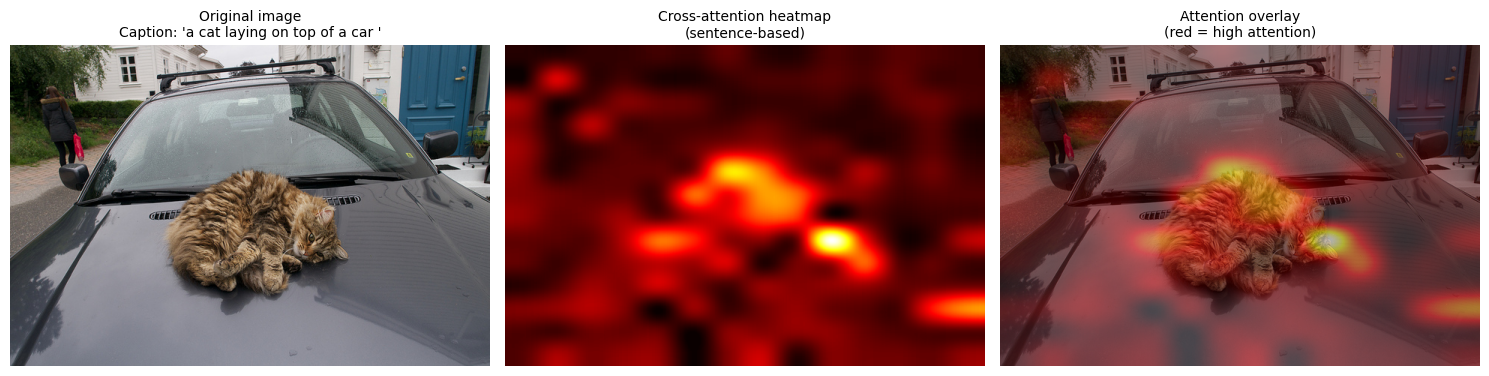

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [15]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

## Attack Pipeline

### Get the Candidate Mask

In [16]:
def get_topk_candidate_pixels(attention_heatmap, k):
    """
    Select top-k pixels with highest attention as candidate region.
    Returns list of (y, x) indices.
    """
    flat = attention_heatmap.flatten()
    k = min(k, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, attention_heatmap.shape)
    return list(zip(ys, xs))


def show_candidate_region(img, attention_heatmap, candidate_pixels):
    """
    Visualize original image and candidate region (pixels we may perturb).
    """
    mask = np.zeros(attention_heatmap.shape, dtype=bool)
    for y, x in candidate_pixels:
        mask[y, x] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Candidate overlay
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap="Reds", alpha=0.6)
    axes[1].set_title("Candidate region (pixels we may perturb)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

ViT-GPT2 caption: 'a cat laying on top of a car '
BLIP caption: 'a cat sleeping on the hood of a car'
Number of candidate pixels: 10000


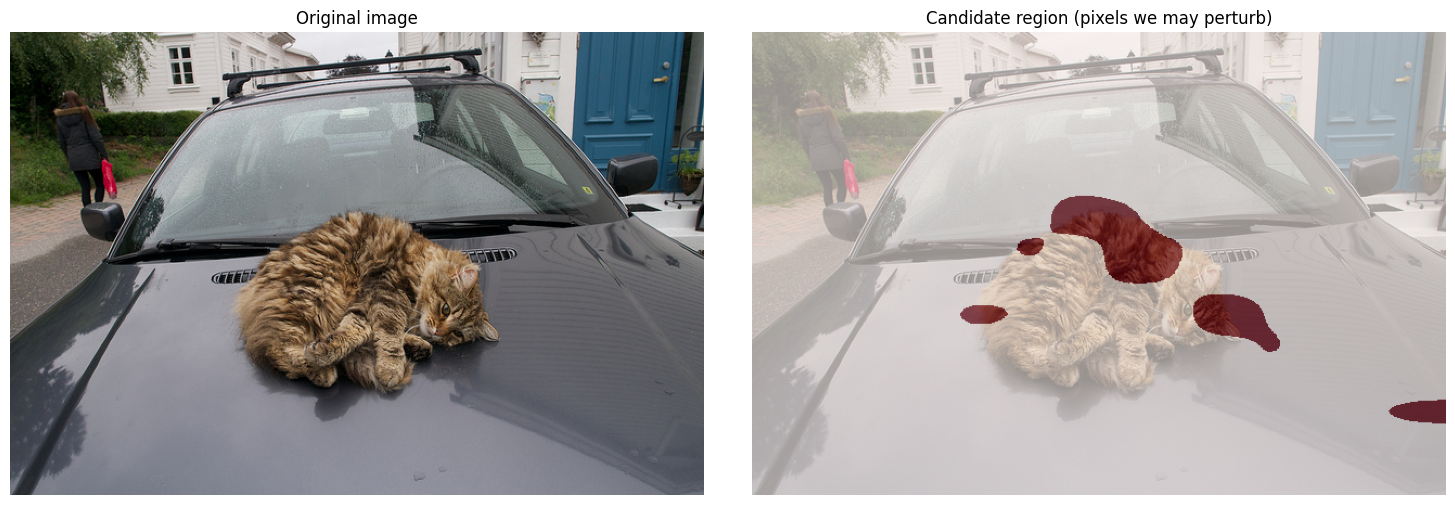

In [19]:
ATTACK_IDX = idx

# Image and Ground Truth Captions
base_img, gt_caps = get_image(ATTACK_IDX)

# Get base captions from BOTH models
base_caption_vit, cross_attentions, _ = generate_caption_and_attention(base_img)
base_caption_blip = generate_blip_caption(base_img)

print(f"ViT-GPT2 caption: '{base_caption_vit}'")
print(f"BLIP caption: '{base_caption_blip}'")
# 3) Attention-Heatmap aggregieren
attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# 4) Top-k Pixel als Candidate Region wählen
candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=10000)

print(f"Number of candidate pixels: {len(candidate_pixels)}")

# 5) Candidate Region visualisieren
show_candidate_region(base_img, attention_heatmap, candidate_pixels)


In [20]:
def image_to_array(img):
    """Convert PIL image to uint8 numpy array of shape (H, W, 3)."""
    return np.array(img).astype(np.uint8)


def array_to_image(arr):
    """Convert numpy array (H, W, 3) back to PIL image."""
    return Image.fromarray(arr.astype(np.uint8))


def apply_perturbation(base_array, delta_vec, candidate_pixels):
    """
    Apply a perturbation vector to the candidate pixels of an image.
    
    base_array: numpy array (H, W, 3), uint8
    delta_vec: 1D numpy array of length 3 * len(candidate_pixels)
               [dR1, dG1, dB1, dR2, dG2, dB2, ...]
    candidate_pixels: list of (y, x) positions
    """
    H, W, C = base_array.shape
    assert C == 3, "Expected RGB image"
    num_pixels = len(candidate_pixels)
    assert delta_vec.shape[0] == 3 * num_pixels, "delta_vec length mismatch"

    # work on a float copy so we can add positive/negative deltas
    perturbed = base_array.astype(np.float32).copy()
    deltas = delta_vec.reshape(num_pixels, 3)

    for (y, x), d in zip(candidate_pixels, deltas):
        # add deltas to this pixel (R,G,B)
        perturbed[y, x, :] += d

    # clip back to valid image range
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    return array_to_image(perturbed)


# base image as numpy array (used for all perturbations)
base_array = image_to_array(base_img)

In [21]:
@torch.no_grad()
def generate_caption(img, max_length=16):
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values, max_length=max_length, num_beams=1)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# Prepare token IDs of the base caption (this is the fixed target for the loss)
base_ids_vit = tokenizer(
    base_caption_vit,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(device)

print(f"Attack target: ViT-GPT2")
print(f"Base caption (ViT-GPT2): '{base_caption_vit}'")
print(f"Reference caption (BLIP): '{base_caption_blip}'")

@torch.no_grad()
def caption_loss_for_image(img):
    """
    Compute cross-entropy loss of the base ViT-GPT2 caption given the image.
    Higher loss = caption less compatible with the image.
    This is only used for ViT-GPT2 (our attack target).
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    outputs = model(pixel_values=pixel_values, labels=base_ids_vit)
    return outputs.loss.item()


# Loss for the original (unperturbed) image
base_loss = caption_loss_for_image(base_img)
print(f"Base loss for original image: {base_loss:.4f}")

Attack target: ViT-GPT2
Base caption (ViT-GPT2): 'a cat laying on top of a car '
Reference caption (BLIP): 'a cat sleeping on the hood of a car'


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Base loss for original image: 9.1638


In [ ]:
# Better fitness with actual caption comparison
@torch.no_grad()
def fitness_caption_change(x):
    """
    Fitness based on actual caption change
    """
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    adv_caption = generate_caption(perturbed_img)
    
    # Jaccard distance between word sets
    base_words = set(base_caption.lower().split())
    adv_words = set(adv_caption.lower().split())
    
    if not base_words or not adv_words:
        overlap = 0.0
    else:
        overlap = len(base_words & adv_words) / len(base_words | adv_words)
    
    # Perturbation size penalty
    norm_penalty = LAMBDA_REG * (np.linalg.norm(x) / (255.0 * np.sqrt(x.size)))
    
    # Lower overlap = better attack
    # Return negative (DE maximizes, we want to minimize overlap)
    fitness_score = -(overlap + norm_penalty)
    
    return fitness_score

# Run with better hyperparameters
LAMBDA_REG = 0.0  # no regularization for first test

best_x, best_f = differential_evolution(
    fitness_fn=fitness_caption_change,
    dim=dim,
    pop_size=20,      # more individuals
    generations=10,   # more iterations
    F=0.8,           # stronger mutation
    CR=0.9,          # higher crossover
    eps=50.0,        # allow stronger perturbations
)

In [ ]:
def differential_evolution(
    fitness_fn,
    dim,
    pop_size=8,
    generations=5,
    F=0.5,
    CR=0.7,
    eps=20.0,
    random_seed=42):
    """
    Very simple Differential Evolution (DE/rand/1/bin).
    
    fitness_fn: function x -> scalar (higher = better)
    dim: dimensionality of x (here: 3 * len(candidate_pixels))
    pop_size: number of individuals in the population
    generations: number of DE generations
    F: mutation factor
    CR: crossover rate
    eps: initial range for parameters: x ~ U[-eps, +eps]
    """
    rng = np.random.default_rng(random_seed)

    # 1) Initialize population with random vectors
    pop = rng.uniform(low=-eps, high=eps, size=(pop_size, dim)).astype(np.float32)
    fitness_vals = np.array([fitness_fn(ind) for ind in pop], dtype=np.float32)

    best_idx = int(np.argmax(fitness_vals))
    best_x = pop[best_idx].copy()
    best_f = float(fitness_vals[best_idx])

    print(f"Initial best fitness: {best_f:.4f}")

    # 2) Iterate over generations
    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        for i in range(pop_size):
            # Choose indices for mutation (a, b, c all different and all != i)
            idxs = list(range(pop_size))
            idxs.remove(i)
            a, b, c = rng.choice(idxs, size=3, replace=False)

            x_a, x_b, x_c = pop[a], pop[b], pop[c]

            # Mutation: v = x_a + F * (x_b - x_c)
            v = x_a + F * (x_b - x_c)

            # Crossover: binomial
            cross_mask = rng.random(dim) < CR
            # Ensure at least one component comes from v
            j_rand = rng.integers(0, dim)
            cross_mask[j_rand] = True

            u = np.where(cross_mask, v, pop[i])

            # Evaluate trial vector
            f_u = fitness_fn(u)

            # Selection: keep trial if it is better
            if f_u > fitness_vals[i]:
                pop[i] = u
                fitness_vals[i] = f_u

                # Update global best if necessary
                if f_u > best_f:
                    best_f = float(f_u)
                    best_x = u.copy()

        print(f"Best fitness after generation {gen + 1}: {best_f:.4f}")

    return best_x, best_f

In [ ]:
# Dimension of the search space
dim = 3 * len(candidate_pixels)
print(f"Dimensionality of x: {dim}")

best_x, best_f = differential_evolution(
    fitness_fn=fitness,
    dim=dim,
    pop_size=6,      # keep small because each call runs the model
    generations=3,   # small number of iterations for testing
    F=0.6,
    CR=0.7,
    eps=20.0,       # allow strong per-channel perturbations
)

print("\n=== Differential Evolution finished ===")
print(f"Best fitness found (loss increase): {best_f:.4f}")

# Create best adversarial image from the found perturbation
best_img = apply_perturbation(base_array, best_x, candidate_pixels)
best_caption = generate_caption(best_img)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(best_img)
plt.title(f"Adversarial\n'{best_caption}'", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"\nOriginal caption : '{base_caption}'")
print(f"Adversarial cap. : '{best_caption}'")
print(f"Base loss        : {base_loss:.4f}")
print(f"Best loss (base+f): {base_loss + best_f:.4f}")

In [ ]:
# Check what magnitudes the DE is actually using
print(f"Best perturbation stats:")
print(f"  Min delta: {best_x.min():.2f}")
print(f"  Max delta: {best_x.max():.2f}")
print(f"  Mean abs:  {np.abs(best_x).mean():.2f}")
print(f"  Std:       {best_x.std():.2f}")

# Check L-infinity norm (max single pixel change)
deltas_reshaped = best_x.reshape(-1, 3)
per_pixel_max = np.abs(deltas_reshaped).max(axis=1)
print(f"\n  L-inf norm (max pixel change): {per_pixel_max.max():.2f}")
print(f"  Number of pixels with change > 10: {(per_pixel_max > 10).sum()}")
print(f"  Number of pixels with change > 30: {(per_pixel_max > 30).sum()}")

In [ ]:
# Install nltk if needed
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference_caption, candidate_caption):
    """
    Compute BLEU score between reference and candidate.
    Lower BLEU = more different = better attack
    """
    ref_tokens = reference_caption.lower().split()
    cand_tokens = candidate_caption.lower().split()
    
    # BLEU needs list of references (can be multiple)
    references = [ref_tokens]
    
    # Smoothing function to avoid zero scores
    smoothing = SmoothingFunction().method1
    
    # Compute BLEU (0 to 1, higher = more similar)
    bleu = sentence_bleu(references, cand_tokens, smoothing_function=smoothing)
    
    return bleu

# Test
test_bleu = compute_bleu(base_caption, base_caption)
print(f"BLEU(same caption): {test_bleu:.4f}")

test_bleu2 = compute_bleu(base_caption, "a dog running in water")
print(f"BLEU(different caption): {test_bleu2:.4f}")

In [ ]:
!pip install nltk

In [ ]:
@torch.no_grad()
def fitness_bleu(x):
    """
    Fitness based on BLEU score (as in the paper).
    Lower BLEU = better attack.
    We return negative BLEU because DE maximizes.
    """
    # Apply perturbation
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    
    # Generate caption
    adv_caption = generate_caption(perturbed_img)
    
    # Compute BLEU score
    bleu = compute_bleu(base_caption, adv_caption)
    
    # L2 penalty for perturbation size
    norm_penalty = LAMBDA_REG * (np.linalg.norm(x) / (255.0 * np.sqrt(x.size)))
    
    # Return negative (DE maximizes, we want to minimize BLEU + penalty)
    return -(bleu + norm_penalty)

# Quick test
print("Testing BLEU-based fitness:")
x_zero = np.zeros(dim, dtype=np.float32)
f_zero = fitness_bleu(x_zero)
print(f"  Fitness(zero perturbation): {f_zero:.4f}")

x_random = np.random.uniform(-50, 50, size=dim).astype(np.float32)
f_random = fitness_bleu(x_random)
print(f"  Fitness(random perturbation): {f_random:.4f}")

In [ ]:
# ============================================
# AICAttack-Style Pipeline v3 (ViT-GPT2)
# - größere Candidate Region
# - Fitness = Caption-Loss + Bonus bei Caption-Change
# - eigene DE-Implementierung (Maximierung)
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1) Hilfsfunktionen für Captioning + Attention
# --------------------------------------------------

@torch.no_grad()
def generate_caption(
    img,
    max_length: int = 20,
    do_sample: bool = False,
    temperature: float = 1.0,
    top_p: float = 0.9,
):
    """
    Wrapper um model.generate für deterministische oder stochastische Captioning.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    gen_kwargs = dict(
        max_length=max_length,
        num_beams=1,
        do_sample=do_sample,
    )
    if do_sample:
        gen_kwargs.update(dict(temperature=temperature, top_p=top_p))

    output_ids = model.generate(pixel_values=pixel_values, **gen_kwargs)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption


@torch.no_grad()
def generate_caption_and_cross_attention(img, max_length: int = 20):
    """
    1) Deterministische Caption
    2) Cross-Attention Maps zu genau dieser Caption
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Schritt 1: deterministische Caption generieren
    gen_ids = model.generate(
        pixel_values=pixel_values,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
    )
    base_caption = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # Schritt 2: Encoder + Decoder mit output_attentions=True
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state

    decoder_outputs = model.decoder(
        input_ids=gen_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False,
    )
    cross_attentions = decoder_outputs.cross_attentions

    return base_caption, cross_attentions


# --------------------------------------------------
# 2) Bild auswählen, Base-Caption + Attention holen
# --------------------------------------------------

ATTACK_IDX = idx  # oder fix eine Zahl wählen
base_img, gt_caps = get_image(ATTACK_IDX)

base_caption, cross_attentions = generate_caption_and_cross_attention(
    base_img,
    max_length=20,
)

attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

# --------------------------------------------------
# 3) Candidate Region: Top-k Attention-Pixel (größer)
# --------------------------------------------------

TOPK_PIXELS = 30000  # vorher 600 → jetzt deutlich mehr Fläche

candidate_pixels = get_topk_candidate_pixels(attention_heatmap, k=TOPK_PIXELS)

print(f"Attack index: {ATTACK_IDX}")
print(f"Base caption: '{base_caption}'")
print(f"Number of candidate pixels: {len(candidate_pixels)}")

show_candidate_region(base_img, attention_heatmap, candidate_pixels)

# --------------------------------------------------
# 4) Vorbereitung für DE
# --------------------------------------------------

base_array = image_to_array(base_img)  # (H, W, 3), uint8
num_pixels = len(candidate_pixels)
dim = 3 * num_pixels  # (dR, dG, dB) pro Pixel

# Base-Caption als Labels für Loss
base_caption_ids = tokenizer(
    base_caption,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(device)


@torch.no_grad()
def caption_loss_for_image(img) -> float:
    """
    Cross-Entropy-Loss der fixen Base-Caption unter dem Bild.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    outputs = model(pixel_values=pixel_values, labels=base_caption_ids)
    return float(outputs.loss)


BASE_LOSS = caption_loss_for_image(base_img)
print(f"\nBase caption loss: {BASE_LOSS:.4f}")

# Attack-Strength: etwas kleiner als vorher, dafür mehr Pixel
EPS_BOUND = 150.0


def clamp_and_fix_dim(delta_vec: np.ndarray, dim: int, bound: float) -> np.ndarray:
    """
    Passt Länge auf 'dim' an und begrenzt Werte auf [-bound, +bound].
    """
    if delta_vec.shape[0] != dim:
        if delta_vec.shape[0] > dim:
            delta_vec = delta_vec[:dim]
        else:
            delta_vec = np.pad(delta_vec, (0, dim - delta_vec.shape[0]), mode="constant")
    return np.clip(delta_vec, -bound, bound)


@torch.no_grad()
def fitness_loss_plus_caption_change(delta_vec: np.ndarray) -> float:
    """
    Fitness für DE:
    - wendet Delta auf Candidate Region an
    - berechnet Caption-Loss
    - generiert stochastische Caption (schneller sensibel für Logit-Shifts)
    - gibt Loss + Bonus, falls Caption != Base zurück
    """
    delta = clamp_and_fix_dim(delta_vec, dim=dim, bound=EPS_BOUND)
    adv_img = apply_perturbation(base_array, delta, candidate_pixels)

    # 1) Loss der Base-Caption
    loss = caption_loss_for_image(adv_img)

    # 2) Stochastische Caption für Change-Bonus
    adv_cap_sample = generate_caption(
        adv_img,
        do_sample=True,
        temperature=1.5,
        top_p=0.9,
    )
    changed = 0.0 if adv_cap_sample.strip() == base_caption.strip() else 1.0

    # Bonus-Weight: Base-Loss liegt ~9, also +5 reicht,
    # um Zustände mit Caption-Change klar zu bevorzugen.
    ALPHA = 5.0
    fitness = loss + ALPHA * changed
    return float(fitness)


# --------------------------------------------------
# 5) Eigene Differential Evolution (Maximierung)
# --------------------------------------------------

def differential_evolution_v2(
    fitness_fn,
    dim: int,
    pop_size: int = 60,
    generations: int = 8,
    F: float = 0.8,
    CR: float = 0.9,
    eps: float = 100,
    random_seed: int = 42,
):
    """
    Klassisches Differential Evolution (DE/rand/1/bin), wir MAXIMIEREN fitness_fn.
    Alle Parameter leben in [-eps, +eps].
    """
    rng = np.random.default_rng(random_seed)

    # Initialpopulation
    pop = rng.uniform(-eps, eps, size=(pop_size, dim))
    fitness = np.array([fitness_fn(ind) for ind in pop])
    best_idx = np.argmax(fitness)
    best = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    print(f"\nInitial best fitness: {best_fit:.4f}")

    for g in range(generations):
        for i in range(pop_size):
            # drei verschiedene Individuen r1, r2, r3
            idxs = np.arange(pop_size)
            idxs = idxs[idxs != i]
            r1, r2, r3 = rng.choice(idxs, size=3, replace=False)
            x1, x2, x3 = pop[r1], pop[r2], pop[r3]

            # Mutation
            mutant = x1 + F * (x2 - x3)

            # Crossover
            cross_points = rng.random(dim) < CR
            if not np.any(cross_points):
                cross_points[rng.integers(0, dim)] = True
            trial = np.where(cross_points, mutant, pop[i])

            # Begrenzen
            trial = np.clip(trial, -eps, eps)

            # Fitness auswerten
            f_trial = fitness_fn(trial)

            # Selektion (MAXIMIEREN)
            if f_trial > fitness[i]:
                pop[i] = trial
                fitness[i] = f_trial
                if f_trial > best_fit:
                    best_fit = f_trial
                    best = trial

        print(f"--- Generation {g+1}/{generations} ---")
        print(f"Best fitness after generation {g+1}: {best_fit:.4f}")

    return best, best_fit


# Hyperparameter für DE
POP_SIZE = 60
GENERATIONS = 2   # etwas höher, damit wir eine Chance auf Caption-Change haben
DE_F = 0.8
DE_CR = 0.9

best_x, best_f = differential_evolution_v2(
    fitness_fn=fitness_loss_plus_caption_change,
    dim=dim,
    pop_size=POP_SIZE,
    generations=GENERATIONS,
    F=DE_F,
    CR=DE_CR,
    eps=EPS_BOUND,
    random_seed=42,
)

print("\n=== Differential Evolution finished ===")
print(f"Best fitness found: {best_f:.4f}  (base loss: {BASE_LOSS:.4f})")

# --------------------------------------------------
# 6) Bestes adversariales Bild + Captions erzeugen
# --------------------------------------------------

best_delta = clamp_and_fix_dim(best_x, dim=dim, bound=EPS_BOUND)
adv_img = apply_perturbation(base_array, best_delta, candidate_pixels)

adv_caption_det = generate_caption(adv_img, do_sample=False)
adv_caption_samp = generate_caption(
    adv_img,
    do_sample=True,
    temperature=1.5,
    top_p=0.9,
)

print("\nBase caption:         ", base_caption)
print("Adv caption (det):    ", adv_caption_det)
print("Adv caption (sample): ", adv_caption_samp)

# --------------------------------------------------
# 7) Visualisierung
# --------------------------------------------------

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"Adversarial\n'{adv_caption_det}'", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()
